# Building a Spam Filter with Naive Bayes

## Table of Contents
* [Introduction](#Introduction)
* [Training and Test Set](#Training-and-Test-Set)
* [Cleaning the Training Set](#Cleaning-the-Training-Set)
* [Calculating Constants](#Calculating-Constants)
* [Calculating Parameters](#Calculating-Parameters)
* [Classifying New Messages](#Classifying-New-Messages)
* [Measuring Filter Accuracy](#Measuring-Filter-Accuracy)
* [Analyzing Incorrect Labels](#Analyzing-Incorrect-Labels)
* [Conclusion](#Conclusion)

## Introduction

Spam messages are irritants that are at best a general nuissance, and at worst, phishing attempts to steal information and cyber attacks that can load a device with viruses. The goal of this project is to create a filter that, with at least 80 percent accuracy, can detect spam messages and classify them as such. To do so, we will use [this dataset](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection) of sms messages to develop our filter. 

Before creating our filter, we will import all necessary Python libraries and read in our dataset.

In [1]:
# importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re

# initialize notebook's plotting capabilities
%matplotlib inline

In [2]:
# reading in table
sms = pd.read_table('/Users/ryanehrhardt/Downloads/SMSSpamCollection', header = None, names = ['Label', 'SMS'])

# verifying data was loaded correctly
print(sms.head())
print('\n')
print(sms.info())

  Label                                                SMS
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


We have now loaded in our data and can see that there are zero null values in the 5,572 rows of the dataset. As an initial anlaysis, we will determine what percent of the dataset are `spam` messages, and how many are `ham` (not spam) messages.

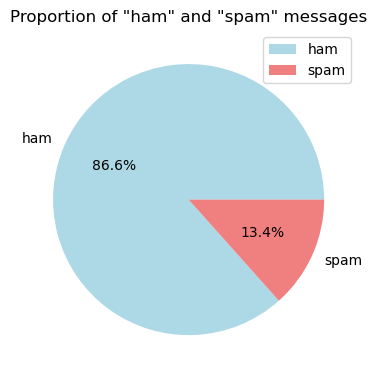

In [3]:
# calculating percent spam
percent_spam = sms['Label'].value_counts(normalize = True)

# create plot showing percent spam
fig, ax = plt.subplots(figsize = (4.4, 4.4))
ax.pie(percent_spam, labels = ['ham', 'spam'], autopct="%1.1f%%", 
      colors = ['lightblue', 'lightcoral'])
ax.set_title('Proportion of "ham" and "spam" messages')
ax.legend(ncol = 1, loc = 'upper right')
plt.show()

After creating our pie chart, we can see that 13.4 percent of the messages in the dataframe are spam messages.

## Training and Test Set

Before creating our filter, we will divide the dataframe `sms` into two sets: a training and a test set. The training set will be a randomly selected 80 percent portion of the dataframe that we will use to improve our filter. The remaining 20 percent of the dataframe will be what we use to test our filter. Our goal is 80 percent accuracy.

We will now create our sets.

In [4]:
# randomizing the dataframe to ensure samples are random
sms_random = sms.sample(random_state = 1, frac = 1)

In [5]:
# assigning training and test sets
training = sms_random.iloc[:4458].reset_index().drop('index', axis = 1)
test = sms_random.iloc[4458:].reset_index().drop('index', axis = 1)

# verifying samples were created successfully 
print(training.head(), '\n', 'length =', len(training))
print('\n')
print(test.head(), '\n', 'length =', len(test))

  Label                                                SMS
0   ham                       Yep, by the pretty sculpture
1   ham      Yes, princess. Are you going to make me moan?
2   ham                         Welp apparently he retired
3   ham                                            Havent.
4   ham  I forgot 2 ask ü all smth.. There's a card on ... 
 length = 4458


  Label                                                SMS
0   ham          Later i guess. I needa do mcat study too.
1   ham             But i haf enuff space got like 4 mb...
2  spam  Had your mobile 10 mths? Update to latest Oran...
3   ham  All sounds good. Fingers . Makes it difficult ...
4   ham  All done, all handed in. Don't know if mega sh... 
 length = 1114


We have now created our training and test datasets. We will now see what propotion of messages in both datasets are spam.

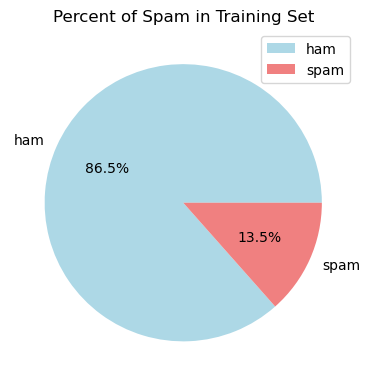

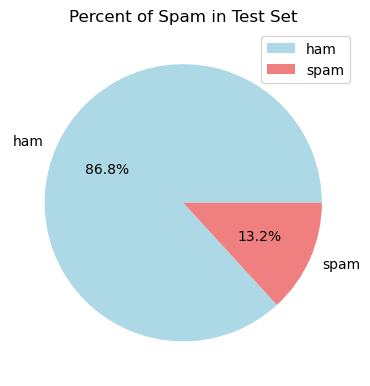

In [6]:
# create percent spam plot for training
training_percent = training['Label'].value_counts()
fig, ax = plt.subplots(figsize = (4.5,4.5))
ax.pie(training_percent, labels = ['ham', 'spam'], autopct="%1.1f%%", 
      colors = ['lightblue', 'lightcoral'])
ax.set_title('Percent of Spam in Training Set')
ax.legend(ncol = 1, loc = 'upper right')
plt.show()

# adds visual seperation between plots
print('\n')

# create percent spam plot for testing
test_percent = test['Label'].value_counts()
fig, ax = plt.subplots(figsize = (4.5,4.5))
ax.pie(test_percent, labels = ['ham', 'spam'], autopct="%1.1f%%", 
      colors = ['lightblue', 'lightcoral'])
ax.set_title('Percent of Spam in Test Set')
ax.legend(ncol = 1, loc = 'upper right')
plt.show()

We can see that 13.2 percent of the messages in our testing set are spam messages and 13.5 percent of messages in our training set are spam messages, which are both very close to the population percentage of 13.4 percent.

## Cleaning the Training Set

We will now begin cleaning our filter. First, we will need to make sure all of the messages are in a usable form. To do this, we will remove any non-numeric or non-letter characters from the training set. We will then convert all characters to lowercase.

In [7]:
# modifying messages
training['SMS'] = training['SMS'].str.replace(r'\W', ' ', regex = True).str.lower()

# verifying data was updated correctly
training.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


We have successfully cleaed our data. Now we will begin creating a series vocabulary that we will use to store the number of occurances of each word in each entry in the training dataset.

In [8]:
# converting each message to an iterable list
training['SMS'] = training['SMS'].str.split()

In [9]:
# initialize empty list to store vocabulary
vocabulary = []

# loop appends each word to the vocabulary list
for entry in training['SMS']:
    for word in entry:
        vocabulary.append(word)

# converts vocabulary to set to remove duplicates
vocabulary = set(vocabulary)
# converts vocabulary back to iterable list
vocabulary = list(vocabulary)

# verifying list was created correctly
print(vocabulary[:10])
print('\n')
print('There are {:,} words in the vocabulary.'.format(len(vocabulary)))

['files', 'cutefrnd', '8077', 'port', 'leona', 'technologies', 'madoke', 'office', 'kiefer', 'tot']


There are 7,783 words in the vocabulary.


Now that we have defined our vocabulary, we will create a dictionary `word_counts_per_sms` that will store the amount of times each word was used in each individual sms message.

In [10]:
# initializing wordcount dictionary with zero values        
word_counts_per_sms = {unique_word: [0] * len(training['SMS']) for unique_word in vocabulary}

# counting instances of each word in each message
for index, sms in enumerate(training['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [11]:
# converting dictionary to a dataframe
word_counts_per_sms_df = pd.DataFrame(word_counts_per_sms)

In [12]:
# concatenate word count dictionary to original dictionary
sms_training = pd.concat([training, word_counts_per_sms_df],axis = 1)

# verify dataframe was created correctly
sms_training.head()

,Label,SMS,files,cutefrnd,8077,port,leona,technologies,madoke,office,...,watevr,uncountable,back,eachother,45239,children,dual,province,wknd,ext
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants

Now that we have prepared our training data, we will calculate our constants for our algorithm that will serve as our spam filter.

In [13]:
# Isolating spam and ham messages
spam_messages = sms_training[sms_training['Label'] == 'spam']
ham_messages = sms_training[sms_training['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(sms_training)
p_ham = len(ham_messages) / len(sms_training)

# number of words in spam messages
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# number of words in ham messages
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# number of words in vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

# checking output
print(p_spam)
print(p_ham)
print(n_spam)
print(n_ham)
print(n_vocabulary)

0.13458950201884254
0.8654104979811574
15190
57237
7783


## Calculating Parameters

Now that we have the constants for our algorithm, we will begin calculating the necessary parameters. Specifically, we will calculate the odds that each word in our vocabulary appears in spam and ham messages. To do this, we will create seperate dictionaries to store the data for both types of messages.

In [14]:
# initializing spam and dictionaries
sms_words_spam = {unique_word: [0] * len(sms_training['Label'] == 'spam') for unique_word in vocabulary}
sms_words_ham = {unique_word: [0] * len(sms_training['Label'] == 'ham') for unique_word in vocabulary}

Now that we've initialized our variables to count the instances for each word, we will create loops that count the number of occurances of a word given it's a ham or spam message, and the probability a word occurs given a ham or spam message.

In [15]:
# loop counts the number of times each word is in a spam message
for index, sms in enumerate(sms_training[sms_training['Label'] == 'spam']['SMS']):
    for word in sms:
        sms_words_spam[word][index] += 1       

In [16]:
# verify dictionary was created successfully
print(sms_words_spam['ipod'][:10])

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [17]:
# loop counts the number of times each word is in a ham message
for index, sms in enumerate(sms_training[sms_training['Label'] == 'ham']['SMS']):
    for word in sms:
        sms_words_ham[word][index] += 1

In [18]:
# verify dictionary was created successfully
print(sms_words_ham['yep'][:10])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now that we've successfully counted the number of times each word has been used in each individual spam and ham messages, we will calculate the total number of times each word has been used across all ham and spam messages.

In [19]:
# initialize dictionaries that count total number of times each word appears in ham and spam messages
word_count_spam = {}
word_count_ham = {}

# counts total instances of each word in a ham or spam message
for word in vocabulary:
    word_count_spam[word] = sum(sms_words_spam[word])
    word_count_ham[word] = sum(sms_words_ham[word])
    
# ensure dictionaries were created correctly
print(word_count_spam['ipod'])
print(word_count_ham['yep'])

11
9


Now that we've calculated the total number of occurances for each word, we will calculate the probability that a word will occur given that the message was either ham or spam.

In [20]:
# initialize dictionaries that calculate probability words will be in ham and spam messages
p_word_spam = {}
p_word_ham = {}

# calculates probability each word will be in a ham or spam message
for word in vocabulary:
    p_word_spam[word] = (word_count_spam[word] + alpha) / (n_spam + alpha * n_vocabulary)
    p_word_ham[word] = (word_count_ham[word] + alpha) / (n_ham + alpha * n_vocabulary)
    
# ensure dictionaries were created correctly
print(p_word_spam['ipod'])
print(p_word_ham['yep'])

0.0005223523266443216
0.00015379883112888343


We have now successfully calculated the probability of certain words appearing in a message given they were spam or ham messages and have all our necessary parameters.

## Classifying New Messages

Now that we have calculated our parameters, we can begin creating our spam filter. To begin, we will create a function that takes in a message as an input, and will output a label of ham, spam, or request that a human makes the final determination in the event that the odds of the message being ham or spam are equal.

In [21]:
def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
        
    # Assigns spam and ham probabilities to be used in multiplication
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
        
    for word in message:
        if word in p_word_spam:
            p_spam_given_message *= p_word_spam[word]
            
        if word in p_word_ham:
            p_ham_given_message *= p_word_ham[word]
    
    # function prints probabilities so we can confirm it labeled correctly
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

We have now created our function, so we will test our function to ensure that it's working properly.

In [22]:
# stores sample messages to check function
messages = ['WINNER!! This is the secret code to unlock the money: C3421.', "Sounds good, Tom, then see u there"]

# loop inputs messages into function
for message in messages:
    classify(message)

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam
P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


We can see that the function ran without a hitch and properly labeled both functions as ham or spam.

## Measuring Filter Accuracy

Now it's time to test the accuracy of our filter on an actual dataset. To do this, we will first slightly modify the function to return only the strings `'ham'` for ham messages, `'spam'` for spam messages, and `'needs human classification'` for messages that are equally likely to be ham and spam.

In [23]:
def classify_test_set(message):
    
    # modifiies message to usable format
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    # assigns probability of a ham or spam message
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    # calculates probability that a message is ham or spam
    for word in message:
        if word in p_word_spam:
            p_spam_given_message *= p_word_spam[word]
            
        if word in p_word_ham:
            p_ham_given_message *= p_word_ham[word]

    # outputs label
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have modified our function, we will apply our function to our test dataframe (`test`) to label it.

In [24]:
# adds series with labels assigned by filter
test['predicted'] = test['SMS'].apply(classify_test_set)

# verify labels were added successfully
test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


We can see that we have successfully labeled the dataframe `test`. Now, we need to test how <b>accurately</b> we labeled `test`. To do that, we will iterate over the dataframe to count how many of the predicted lables matched the actual labels, and use that value to determine the percentage of accurate labels.

In [25]:
# initialize variables for calculations
total = len(test) # total number of messages
count = 0 # will count total accurate messages

# loop outputs number of correct labels
for i, row in test.iterrows():
    label = row['Label']
    predicted_label = row['predicted']
    if label == predicted_label:
        count += 1
    
# calculating and displaying percent accuracy
accuracy = count / total * 100
print('The filter is {:.2f} percent accurate.'.format(accuracy))

The filter is 98.74 percent accurate.


We can see that our filter's labels are 98.74 percent accurate on the test dataset, which is a near perfect score and certainly much better than the goal of 80 percent accurate we outlined in our introduction.

## Analyzing Incorrect Labels

We will now examine the incorrect labels generated by the filter and try to figure out where it went wrong.

In [26]:
# initialize variables to store incorrect labels and messages
wrong_label = []
message = []
wrong_message_label = []

# loop outputs number of correct labels
for i, row in test.iterrows():
    label = row['Label']
    predicted_label = row['predicted']
    if label != predicted_label:
        wrong_label.append(row['predicted'])
        message.append(row['SMS'])
        wrong_message_label.append(row)

# print incorrect labels and messages
print(wrong_label)
print(message)
pd.DataFrame(wrong_message_label)

['ham', 'ham', 'spam', 'spam', 'spam', 'needs human classification', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham']
['Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net', "More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB", 'Unlimited texts. Limited minutes.', '26th OF JULY', 'Nokia phone is lovly..', 'A Boy loved a gal. He propsd bt she didnt mind. He gv lv lttrs, Bt her frnds threw thm. Again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal. Wn it was about 2 hit d girl,d boy ran like hell n saved her. She asked \'hw cn u run so fast?\' D boy replied "Boost is d secret of my energy" n instantly d girl shouted "our energy" n Thy lived happily 2gthr drinking boost evrydy Moral of d story:- I hv free msgs:D;): gud ni8', 'No calls..messages..

,Label,SMS,predicted
114,spam,Not heard from U4 a while. Call me now am here...,ham
135,spam,More people are dogging in your area now. Call...,ham
152,ham,Unlimited texts. Limited minutes.,spam
159,ham,26th OF JULY,spam
284,ham,Nokia phone is lovly..,spam
293,ham,A Boy loved a gal. He propsd bt she didnt mind...,needs human classification
302,ham,No calls..messages..missed calls,spam
319,ham,We have sent JD for Customer Service cum Accou...,spam
504,spam,Oh my god! I've found your number again! I'm s...,ham
546,spam,"Hi babe its Chloe, how r u? I was smashed on s...",ham


Two things that consistently occur in the messages mislabeled as ham is that the messages are soliciting sex work in some way, and the messages are asking for the recipient to give up some sort of personal information. 

Among the messages mislabeled as spam, one thing we're finding is that there's language that occurs, such as 'Nokia phone is lovly..' that may be consistient with spam sales messages. There's also many typos, text shorthands, and words and syntax that just generally stray from classic grammatical structures, all of which may be more likely to be considered spam.

In terms of how to improve the accuracy even more, it seems that the main solution would be to continue to train the filter with larger and larger sets of data. This should cut down on the discrepancies that exist labeling, though it won't ever make the filtering process perfect, as the language for these mislabeled messages will likely always exist in a gray area that the filter may have issues identifying.

## Conclusion

* We created a filter that correctly labels incoming sms messages as spam or ham 98.74 percent of the time.
* <b>Issues</b>
  * <u>Spam messages</u> soliciting sex and attempting to steal personal information are most liikely to be mislabeled as spam.
  * <u>Ham messages</u> with unconventional or incorrect grammar, as well as messages with language that is reminiscent of spam sales messages, are more likely to be incorrectly flagged as spam.
  * The best way to improve the filter is to expand its vocabulary and train it on a much larger dataset.